In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, dim)

    def forward(self, t):
        # sinusoidal embedding
        half_dim = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half_dim, device=t.device).float()/half_dim)
        t = t.unsqueeze(1).float()
        sinusoid = torch.cat([torch.sin(t*freqs), torch.cos(t*freqs)], dim=1)
        return self.linear(sinusoid)

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: [B,3,128,128] -> [B,512,8,8]
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 128x32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 256x16x16
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), # 512x8x8
            nn.ReLU()
        )

        # Latent parameters
        self.enc_fc_mu = nn.Linear(512*8*8, latent_dim)
        self.enc_fc_std = nn.Linear(512*8*8, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 512*8*8)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # [B,256,16,16]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # [B,128,32,32]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [B,64,64,64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # [B,3,128,128]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(x.size(0), -1)
        mu = self.enc_fc_mu(h)
        log_std = self.enc_fc_std(h)
        std = F.softplus(log_std)
        return mu, std

    def reparameterize(self, mu, std):
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(z.size(0), 512, 8, 8)
        x_recon = self.dec_conv(h)
        return x_recon

    def forward(self, x):
        mu, std = self.encode(x)
        z = self.reparameterize(mu, std)
        x_recon = self.decode(z)
        return x_recon, mu, std

In [ ]:
class LatentUNet(nn.Module):
    def __init__(self, latent_dim=128, time_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_embed = TimeEmbedding(dim=time_dim)

        # Input: z_t [B,128], z_gray [B,128], t_embed [B,128]

        self.fc = nn.Linear(latent_dim*2 + time_dim, latent_dim*4*4)  # produce the output with the shape of [B,128*4*4]
        # Reshape to [B,128,4,4]

        # Downsample
        self.down1 = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim*2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(latent_dim*2, latent_dim*2, 3, padding=1),
            nn.ReLU()
        )

        # Middle
        self.mid = nn.Sequential(
            nn.Conv2d(latent_dim*2, latent_dim*2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(latent_dim*2, latent_dim*2, 3, padding=1),
            nn.ReLU()
        )

        # Upsample
        self.up1 = nn.Sequential(
            nn.Conv2d(latent_dim*2, latent_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
            nn.ReLU()
        )

        self.conv_out = nn.Conv2d(latent_dim, latent_dim, 3, padding=1)

    def forward(self, z_t, z_gray, t):
        # z_t, z_gray: [B,128]
        t_embed = self.time_embed(t) # [B, 128]
        inp = torch.cat([z_t, z_gray, t_embed], dim=1) # [B,128*2+128=384]

        h = self.fc(inp) # [B,128*4*4]
        h = h.view(-1, 128, 4, 4) # [B,128,4,4]

        # U-Net forward (having down, mid and up)
        # down
        d1 = self.down1(h)   # [B,256,4,4]

        # mid
        m = self.mid(d1)     # [B,256,4,4]

        # up
        u1 = self.up1(m)     # [B,128,4,4]

        # Combine with skip:
        u1 = u1 + h

        out = self.conv_out(u1)  # [B,128,4,4]

        # get back to the shape of [B,128] for noise prediction
        out = out.view(out.size(0), -1)  # [B,128*4*4=2048]
        out = nn.functional.adaptive_avg_pool2d(out.view(-1,128,4,4), (1,1)).view(-1,128)
        return out


In [ ]:
def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

def calc_alpha_bars(betas):
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return alpha_bars

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gray_path = 'drive/MyDrive/DL_project/image_batch_gray.npy'
f_gray = np.load(gray_path)
print(f_gray.shape)

(10000, 128, 128)


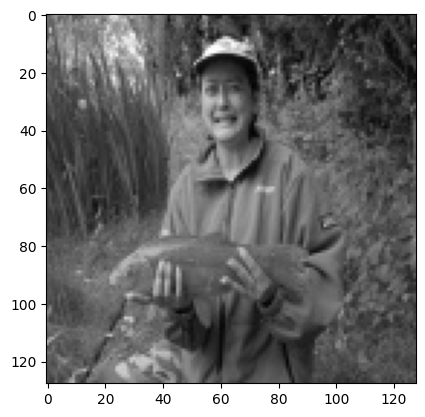

In [ ]:
plt.imshow(f_gray[0], cmap='gray')

In [ ]:
color_path = 'drive/MyDrive/DL_project/image_batch_rgb.npy'
f_color = np.load(color_path)
print(f_color.shape)

(10000, 128, 128, 3)


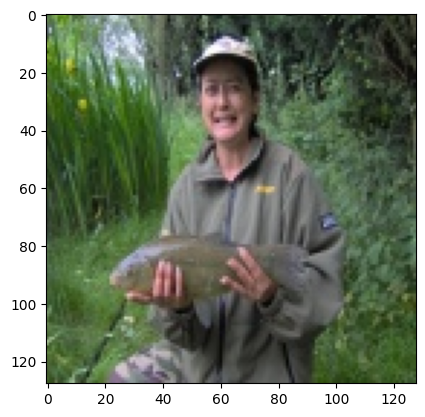

In [ ]:
plt.imshow(f_color[0])

In [ ]:
# this class can convert the input images to the form of Tensor for model use
class gray_n_rgb_dataset(Dataset):
    def __init__(self, gray_images, color_images):
        self.gray_images = gray_images
        self.color_images = color_images

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, index):
        gray = torch.tensor(self.gray_images[index], dtype=torch.float32).unsqueeze(0)/255.0
        color = torch.tensor(self.color_images[index], dtype=torch.float32).permute(2, 0, 1)/255.0
        return gray, color

In [ ]:
train_dataset = gray_n_rgb_dataset(f_gray, f_color)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Train the VAE model with the chosen lr and epoches
# future consideration: try the other parameters in optimizer
vae = ConvVAE(latent_dim=128).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=1e-3)

num_vae_epochs = 1000
for epoch in range(num_vae_epochs):
    vae.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    for x_gray, x_color in train_loader:
        x_color = x_color.to(device)

        x_recon, mu, std = vae(x_color)

        recon_loss = F.mse_loss(x_recon, x_color)
        kl_loss = 0.5 * torch.mean(mu**2 + std**2 - torch.log(std**2 + 1e-8) - 1)
        loss_vae = recon_loss + 0.001 * kl_loss

        optimizer_vae.zero_grad()
        loss_vae.backward()
        optimizer_vae.step()

        total_loss += loss_vae.item() * x_color.size(0)
        total_recon += recon_loss.item() * x_color.size(0)
        total_kl += kl_loss.item() * x_color.size(0)
    if (epoch + 1) % 50 == 0:
      print(f"Epoch {epoch+1}/{num_vae_epochs}: VAE Loss {total_loss/len(train_loader):.4f}, Recon {total_recon/len(train_loader):.4f}, KL {total_kl/len(train_loader):.4f}")
      print("=================================================================")


Epoch 50/1000: VAE Loss 0.6098, Recon 0.4797, KL 130.1134
Epoch 100/1000: VAE Loss 0.5420, Recon 0.4097, KL 132.2829
Epoch 150/1000: VAE Loss 0.5126, Recon 0.3788, KL 133.7473
Epoch 200/1000: VAE Loss 0.4945, Recon 0.3598, KL 134.7280
Epoch 250/1000: VAE Loss 0.4838, Recon 0.3481, KL 135.6866
Epoch 300/1000: VAE Loss 0.4756, Recon 0.3392, KL 136.4239
Epoch 350/1000: VAE Loss 0.4684, Recon 0.3315, KL 136.9181
Epoch 400/1000: VAE Loss 0.4623, Recon 0.3248, KL 137.4583
Epoch 450/1000: VAE Loss 0.4580, Recon 0.3202, KL 137.8803
Epoch 500/1000: VAE Loss 0.4556, Recon 0.3172, KL 138.3724
Epoch 550/1000: VAE Loss 0.4532, Recon 0.3145, KL 138.6194
Epoch 600/1000: VAE Loss 0.4499, Recon 0.3109, KL 138.9502
Epoch 650/1000: VAE Loss 0.4475, Recon 0.3083, KL 139.2840
Epoch 700/1000: VAE Loss 0.4464, Recon 0.3069, KL 139.5725
Epoch 750/1000: VAE Loss 0.4438, Recon 0.3042, KL 139.6645
Epoch 800/1000: VAE Loss 0.4418, Recon 0.3018, KL 139.9453
Epoch 850/1000: VAE Loss 0.4415, Recon 0.3014, KL 140.157

In [ ]:
# train the ldm with VAE
T = 1000
betas = linear_beta_schedule(T).to(device)
alpha_bars = calc_alpha_bars(betas)

ldm = LatentUNet(latent_dim=128, time_dim=128).to(device)
optimizer_diff = optim.Adam(ldm.parameters(), lr=1e-4)

num_diffusion_epochs = 500
for epoch in range(num_diffusion_epochs):
    ldm.train()
    for x_gray, x_color in train_loader:
        x_gray = x_gray.to(device)
        x_color = x_color.to(device)

        with torch.no_grad():
            mu_col, std_col = vae.encode(x_color)
            z_color = vae.reparameterize(mu_col, std_col)  # [B,128]

            x_gray_3ch = x_gray.repeat(1,3,1,1)
            mu_gray, std_gray = vae.encode(x_gray_3ch)
            # We can use just mu_gray as the condition
            z_gray = mu_gray

        t = torch.randint(low=1, high=T, size=(x_color.size(0),), device=device)
        epsilon = torch.randn_like(z_color)

        alpha_bar_t = alpha_bars[t-1].unsqueeze(1)
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        z_t = sqrt_alpha_bar_t * z_color + sqrt_one_minus_alpha_bar_t * epsilon

        noise_pred = ldm(z_t, z_gray, t)

        loss_diff = ((noise_pred - epsilon)**2).mean()

        optimizer_diff.zero_grad()
        loss_diff.backward()
        optimizer_diff.step()
    if (epoch + 1) % 50 == 0:
      print(f"Epoch {epoch+1}/{num_diffusion_epochs}, DiffLoss: {loss_diff.item():.4f}")
      print("=================================================================")

Epoch 50/500, DiffLoss: 0.2623
Epoch 100/500, DiffLoss: 0.1740
Epoch 150/500, DiffLoss: 0.1254
Epoch 200/500, DiffLoss: 0.1692
Epoch 250/500, DiffLoss: 0.1089
Epoch 300/500, DiffLoss: 0.1306
Epoch 350/500, DiffLoss: 0.1095
Epoch 400/500, DiffLoss: 0.1166
Epoch 450/500, DiffLoss: 0.0289
Epoch 500/500, DiffLoss: 0.0943


In [ ]:
# save the models
torch.save(vae, 'drive/MyDrive/DL_project/vae_weights.pth')
torch.save(ldm, 'drive/MyDrive/DL_project/ldm_weights.pth')

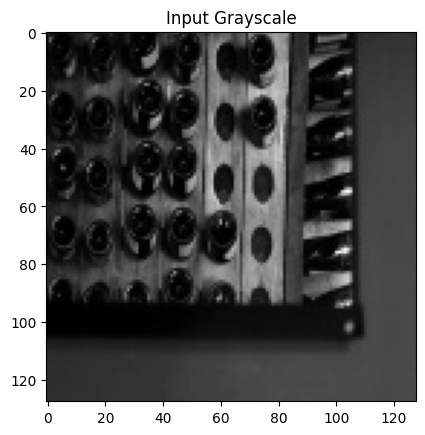

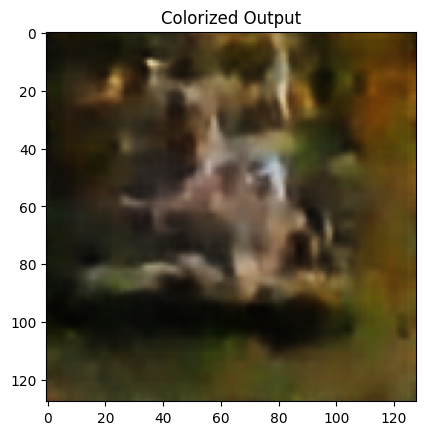

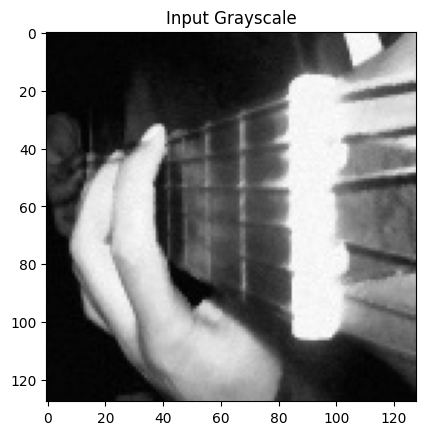

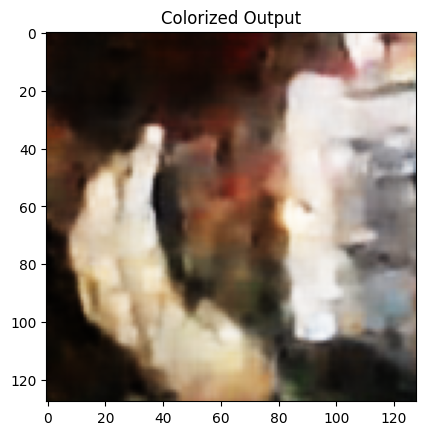

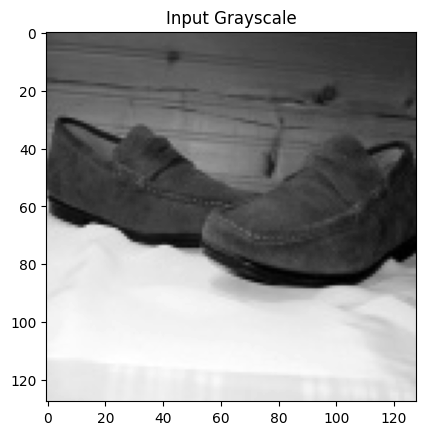

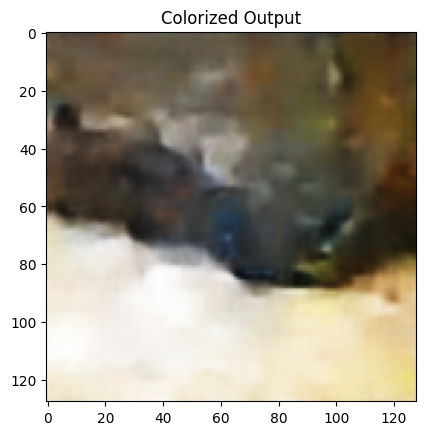

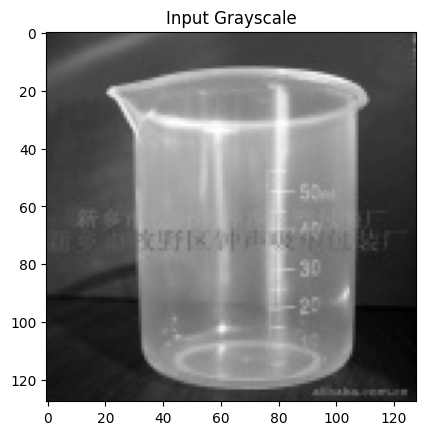

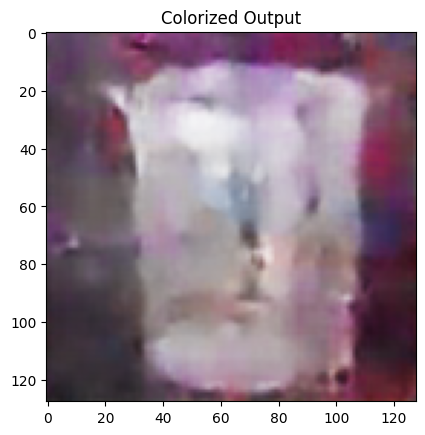

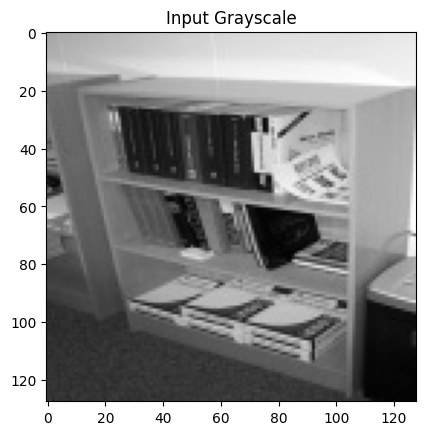

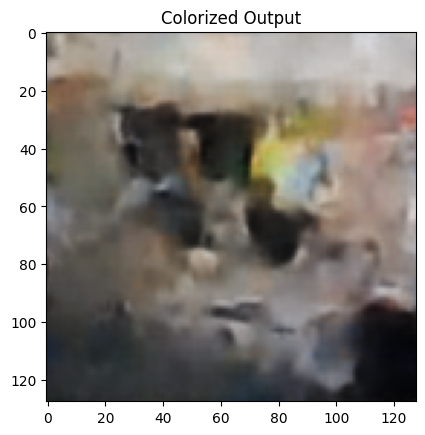

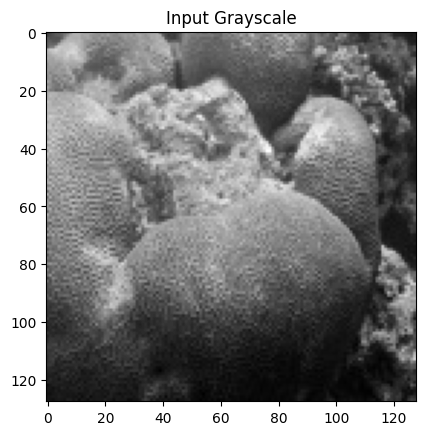

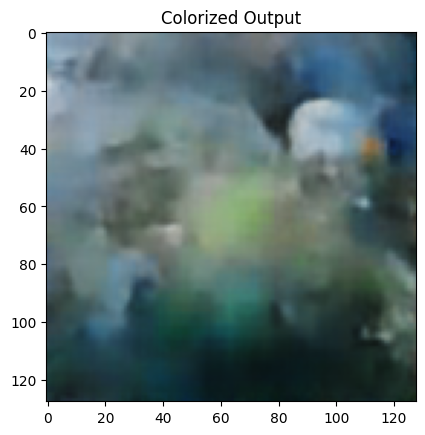

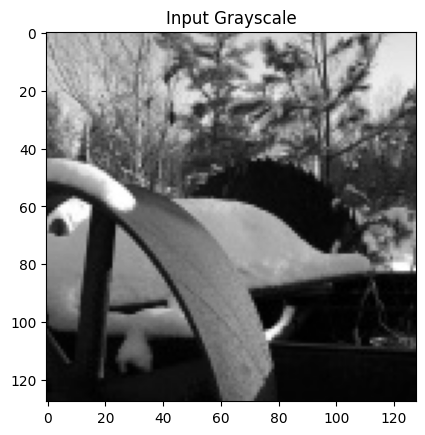

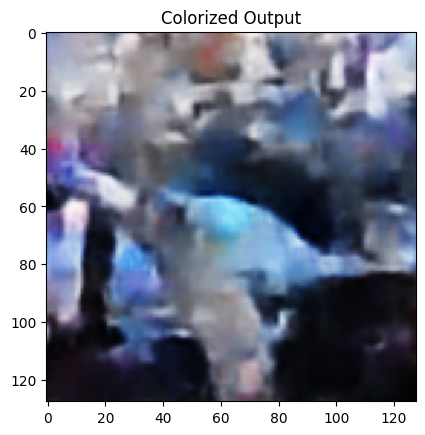

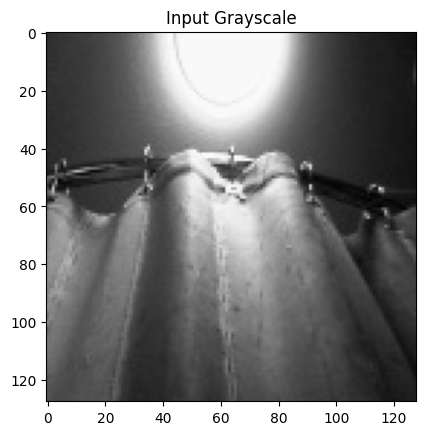

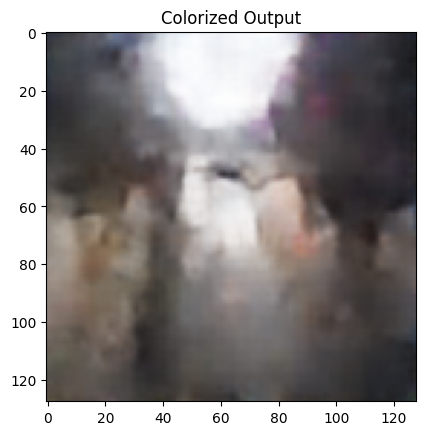

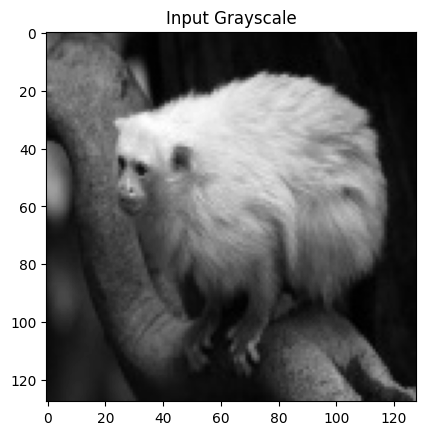

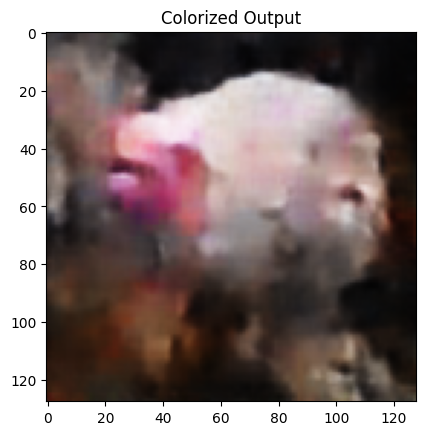

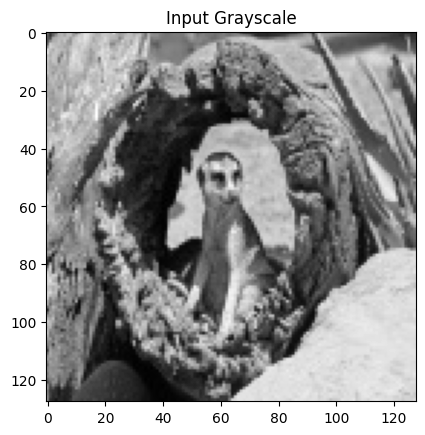

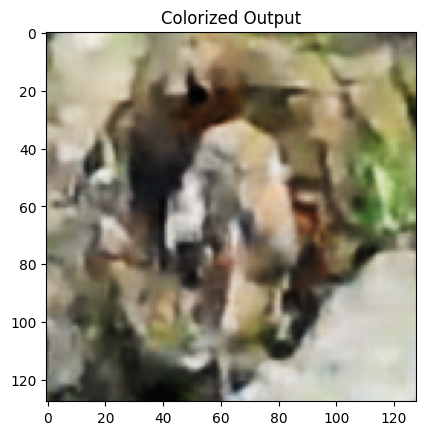

In [ ]:
# Try to colorize 10 random images
for i in range(10):
  index = random.randint(0, len(f_gray)-1)
  test_gray = torch.tensor(f_gray[index], dtype=torch.float32).unsqueeze(0).unsqueeze(0)/255.0
  plt.imshow(test_gray[0,0].cpu().numpy(), cmap='gray')
  plt.title("Input Grayscale")
  plt.show()

  test_gray = test_gray.to(device)
  with torch.no_grad():
      x_gray_3ch = test_gray.repeat(1,3,1,1)
      mu_gray, std_gray = vae.encode(x_gray_3ch)
      z_gray = mu_gray

  z_T = torch.randn_like(z_gray)
  alphas = 1.0 - betas

  for step in reversed(range(1, T+1)):
      t_tensor = torch.tensor([step], device=device)
      with torch.no_grad():
          noise_pred = ldm(z_T, z_gray, t_tensor)

      alpha_bar_t = alpha_bars[step-1]
      alpha_t = alphas[step-1]
      beta_t = betas[step-1]

      sqrt_alpha_t = torch.sqrt(alpha_t)
      sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
      z_0_est = (z_T - (1 - alpha_t)/sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_t

      if step > 1:
          sigma_t = torch.sqrt(beta_t)
          z_T = z_0_est + sigma_t * torch.randn_like(z_T)
      else:
          z_T = z_0_est

  z_0 = z_T
  with torch.no_grad():
      x_colorized = vae.decode(z_0)
  x_colorized = x_colorized.clamp(0,1)

  colorized_img = x_colorized[0].cpu().permute(1,2,0).numpy()
  plt.imshow(colorized_img)
  plt.title("Colorized Output")
  plt.show()